<a href="https://colab.research.google.com/github/myatmo/Seeing_is_Believing/blob/master/EAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Troubleshooting

Note: If it fails to upload the image from Drive, login to umn account again. It's caused by the authentication factor needed by umn account.

Don't change the directory to images. The model needs to be accessed and it is not under images directory!

# Imports

In [1]:
# import all necessary libraries for detection
import cv2 as cv
from google.colab.patches import cv2_imshow # replacement for cv2.imshow() for use in Jupyter notebooks.
import numpy as np
import time
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt

# import for connecting webcam with javascript
import base64
import html
import io
from IPython.display import display, Javascript, clear_output
from IPython.display import Image as IPy_img
from google.colab.output import eval_js
from PIL import Image

# import for video input
from imutils.video import VideoStream # to access webcam
from imutils.video import FPS
import imutils


# Mouting Google Drive

In [2]:
# mounting google drive to access images
from google.colab import drive
drive.mount('/content/drive')

# change the working directory if not it'll have problem when loading the pre-trained model
%cd drive/My Drive/Colab Notebooks/Appa/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Appa


# Functions

## Load and Prepare Image

In [3]:
'''
Read the input image and convert colour to RGB
input:  path to the image and name of the image
return: image matrix
'''
def load_image(image_name):
  # load the image
  image = cv.imread(image_name)
  # colour correction; OpenCV uses BGR thus need to convert to RGB
  # only use when using with matplotlib; since colab doesn't support cv.imshow
  #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

  return image

In [4]:
'''
Resize it according to the input height and width
input:  image name, height and width (int)
return: new resized image, rh (ratio changes in height) and rw (ratio changes in width)
'''
def prepare_image(image, height, width):
  # grab the image dimensions
  (origH, origW) = image.shape[:2]

  # set new height and width and calculate the ratio in changes
  (newH, newW) = (height, width) # you can change the size to any multiple of 32
  rh = origH / float(newH)
  rw = origW / float(newW)

  # resize the image
  image = cv.resize(image, (newW, newH))

  return image, rh, rw

In [5]:
'''
plot image
input:  the image matrix
'''
def plot_image(image):
  # plot the image
  plt.imshow(image)
  plt.show()

## Load EAST

In [6]:
'''
Feed the image into EAST model
input:  new resized image, EAST model path
return: scores and geometry (bounding box coordinates)
'''
def load_east_model(image, east):
  # define output layer for EAST detector model; the first one is sigmoid for output probabilities, and
  # the second one is for the bounding box coordinates
  outputLayers = [
                "feature_fusion/Conv_7/Sigmoid",
                "feature_fusion/concat_3"
  ]
  
  # load the pre-trained EAST text detector model
  net = cv.dnn.readNet(east)

  # grab the image dimensions
  (H, W) = image.shape[:2]
  blob = cv.dnn.blobFromImage(image, 1.0, (W, H), 
                              (123.68, 116.78, 103.94), swapRB=True, crop=False)

  # pass the input image through the network
  net.setInput(blob)

  # forward pass to get two feature maps: scores and geometry
  (scores, geometry) = net.forward(outputLayers)

  return (scores, geometry)

## Construct Bounding Boxes

In [7]:
'''
Clean up data that have low probability in scores and extract rects that contains the coordinates of bounding boxes from geometry
input:  scores, geometry returned from EAST model and min_confidence
return: rects (startX, startY, endX, endY coordinates) and confidences (probability values associated with each bounding box in rects)
'''
def construct_bounding_boxes(scores, geometry, min_confidence):
  # get the volume of scores; scores.shape = (1, 1, 80, 80) and geo.. is (1, 5, 80, 80); 80 can be any number (depends on the image size)
  (rows, cols) = scores.shape[2:4]

  # check if the score has high probability; if not ignore it
  mask = (scores > min_confidence).astype(scores.dtype)

  # multiplying by score_mask makes all the low prob that is less than min_confidences zero
  confidences = (scores * mask).flatten().reshape(rows*cols, 1) # the probability associated with each bounding box
  geoData = (geometry * mask).reshape(geometry.shape[1], rows*cols).T

  # reduce the dimensions of scoreData and geoData by removing rows that have zeros values
  confidences = confidences[~np.all(confidences==0, axis=1)]
  geoData = geoData[~np.all(geoData==0, axis=1)]

  # extract geometrical data (x1, y1, x2, y2 and angle) from geoData
  x1 = geoData[:, [0]]
  y1 = geoData[:, [1]]
  x2 = geoData[:, [2]]
  y2 = geoData[:, [3]]
  angle = geoData[:, [4]]

  # compute the offeset factor; the resulting feature maps is 4 times smaller than the input image
  offset_mask = mask.reshape(mask.shape[2], mask.shape[3])
  offset_value = np.array(np.where(offset_mask==1)).T*4.0
  n = x1.shape[0]
  assert(offset_value.shape == (n, 2))  # jsut to make sure that the dimension of offset_value is the same as that of x1, y1, x2 etc.
  
  # compute starting x,y and ending x,y of the bounding box
  endX = (offset_value[:,1].reshape(n, 1) + (np.cos(angle)*y1) + (np.sin(angle)*x2)).astype(int)
  startX = (endX - (y1 + y2)).astype(int)

  endY = (offset_value[:,0].reshape(n, 1) - (np.sin(angle)*y1) + (np.cos(angle)*x2)).astype(int)
  startY = (endY - (x1 + x2)).astype(int)

  # stack startX, startY, endX, endY together in column wise
  rects = np.column_stack((startX, startY, endX, endY)) # the bounding box coordinate (x, y) for text regions

  return (rects, confidences)

## Apply Non-Maxima Suppression

In [8]:
'''
Apply non-maxima suppression for overlapping bounding boxes
input:  rects (startX, startY, endX, endY coordinates) and confidences (probability values associated with each bounding box in rects)
return: unique bounding boxes
'''
def apply_nms(rects, confidences):
  # reshape and convert confidences (numpy array) into list
  prob_list = confidences.flatten()
  prob_list = prob_list.tolist()
  
  # call non-maxima suppression
  boxes = non_max_suppression(rects, probs=prob_list)

  return boxes

## Draw Bounding Boxes

In [9]:
'''
Draw bounding boxes on the original image
input:  the bounding boxes after nms, original image matrix (before resizing), rh (ratio changes in height) and rw (ratio changes in width)
'''
def draw_boxes(boxes, image, rh, rw):
  # loop over the bounding boxes
  for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective ratio
    startX = int(startX * rw)
    startY = int(startY * rh)
    endX = int(endX * rw)
    endY = int(endY * rh)

    # draw the bounding box on the original image
    cv.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Text Detection on Images

## Main Function

In [10]:
'''
Main function to run EAST text detection
input:  image name, height and width (for resizing image), EAST model file, minimum confidence value
output: bounding boxes on the text areas drawn on the original image
'''
def detect_text(image_name, height, width, east, min_confidence):
  # load and resize image
  orig_image = load_image(image_name)
  image, rh, rw = prepare_image(orig_image, height, width)

  start = time.time()
  # load EAST model and get scores and geometry (coordinates of bounding boxes)
  print("loading EAST text detector...")
  (scores, geometry) = load_east_model(image, east)
  end = time.time()
  print("text detection took %.6f seconds" % (end-start))
  print("scores and geometry shape: ", scores.shape, geometry.shape)

  start = time.time()
  # clean up low probabilities in scores and geomety then construct bounding boxes
  (rects, confidences) = construct_bounding_boxes(scores, geometry, min_confidence)
  end = time.time()
  print("total time: %.6f seconds" % (end-start))
  print("rects and confidences shape: ", rects.shape, confidences.shape)

  # apply non maxima suppression
  boxes = apply_nms(rects, confidences)
  #boxes = non_max_suppression_slow(rects.tolist(), 0.6)
  print("bb shape: ", boxes.shape)

  draw_boxes(boxes, orig_image, rh, rw)
  cv2_imshow(orig_image)
  #plot_image(orig_image)

  

## Testing with images

loading EAST text detector...
text detection took 12.406013 seconds
scores and geometry shape:  (1, 1, 80, 80) (1, 5, 80, 80)
total time: 0.002101 seconds
rects and confidences shape:  (204, 4) (204, 1)
bb shape:  (12, 4)


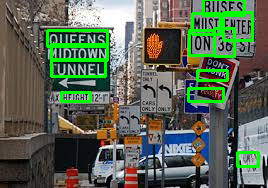

In [11]:
# define image path on drive and image name
image_name = "images/img4.jpg" # change your own image name here
east = 'frozen_east_text_detection.pb'  # path to the model; make sure the model is loaded to the working directory
width = height = 320
min_confidence = 0.6

# test detect_text
detect_text(image_name, height, width, east, min_confidence)

In [ ]:
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
  # keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]

    # loop over all indexes in the indexes list
		for pos in xrange(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]
  

In [ ]:
old_time = 0.020355
new_time = 0.000590
percent = (old_time-new_time)/old_time * 100
rate = old_time/new_time
print("Improved version: %.f times faster" % rate)

Improved version: 34 times faster


# Real-time Text Detection

## Javascript to access webcam

In [12]:
'''
javascript to take input from webcam
'''
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [13]:
def js_reply_to_image(js_reply):
  """
  input: 
        js_reply: JavaScript object, contain image from webcam
  output: 
        image_array: image array RGB from webcam
  """
  jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
  image_PIL = Image.open(io.BytesIO(jpeg_bytes))
  image_array = np.array(image_PIL)

  return image_array

In [43]:
def drawing_array_to_bytes(drawing_array):
  """
  input: 
        drawing_array: image RGBA contain bounding box and text from prediction
                      
  output: 
        drawing_b64: string, encoded from drawing_array
  """
  drawing_PIL = Image.fromarray(drawing_array, 'RGB')
  iobuf = io.BytesIO()
  drawing_PIL.save(iobuf, format='png')
  drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
  return drawing_bytes

## Main program

In [30]:
east = 'frozen_east_text_detection.pb'  # path to the model; make sure the model is loaded to the working directory
width = height = 320
min_confidence = 0.6

In [45]:
start_input()
label_html = 'Capturing...'
img_data = ''

def get_drawing_array(image, boxes):
  drawing_array = np.zeros([512, 512, 4], dtype=np.uint8)
  drawing_array[:,:,:3] = image
  drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255
  draw_boxes(boxes, drawing_array, rh, rw)

  return drawing_array

while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
  
  image = js_reply_to_image(js_reply)
  train_img, rh, rw = prepare_image(image, height, width)
  
  # load EAST model and get scores and geometry (coordinates of bounding boxes)
  (scores, geometry) = load_east_model(train_img, east)

  # clean up low probabilities in scores and geomety then construct bounding boxes
  (rects, confidences) = construct_bounding_boxes(scores, geometry, min_confidence)

  # apply non maxima suppression
  boxes = apply_nms(rects, confidences)
  draw_boxes(boxes, image, rh, rw)

  #drawing_array = get_drawing_array(image, boxes)
  drawing_bytes = drawing_array_to_bytes(image)
  img_data = drawing_bytes
  #print(img_data)

<IPython.core.display.Javascript object>

## Video Input

In [ ]:
def arrayShow(imageArray):
  ret, png = cv.imencode('.png', imageArray)
  encoded = base64.b64encode(png)
  return IPy_img(data=encoded.decode('ascii'))
  

In [17]:
video_input = "images/video.mp4"
def detect_on_videos(video_input):
  cap = cv.VideoCapture(video_input)
  cap.set(cv.CAP_PROP_POS_FRAMES, 1000)
  fps = FPS().start()

  while (cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
      break
    
    clear_output(wait=True)
    
    # resize the frame, maintaining the aspect ratio
    #frame = cv.resize(frame, (width, height))
    orig = frame.copy()
    frame, rh, rw = prepare_image(frame, height, width)
    
    # load EAST model and get scores and geometry (coordinates of bounding boxes)
    (scores, geometry) = load_east_model(frame, east)

    # clean up low probabilities in scores and geomety then construct bounding boxes
    (rects, confidences) = construct_bounding_boxes(scores, geometry, min_confidence)

    # apply non maxima suppression
    boxes = apply_nms(rects, confidences)

    draw_boxes(boxes, orig, rh, rw)
    #img = arrayShow(frame)
    #display(img)
    fps.update()
    key = cv.waitKey(1) & 0xFF
    if key == ord("q"):
      break

  fps.stop()
  cap.release()

  

In [19]:
detect_on_videos(video_input)

# OCR

In [50]:
!pip install pytesseract
!pip install pillow


  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=2cb1d2798116e252f50fd0220d919f25b943e04fabfd755fe7db42e57790e6bd
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [54]:
import cv2 as cv
import pytesseract as ts
import imutils

# References

https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

https://towardsdatascience.com/yolov3-pytorch-streaming-on-google-colab-16f4fe72e7b
